In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
#Define Timescape constants
G_SI = 4.49e-15           # gravitational constant, Mpc^3/ (Gyrs^2 * Msolar)
c_SI = 3.06e2             # speed of light in vacuum, Mpc/Gyrs
fv0 = 0.737               # void fraction at the current time
H0_SI = 7.47e-2           # Gyrs^-1, which is 73.23 km/(s*Mpc) -- a reasonable standard late time H0 


In [3]:
# Convert to proper units, i.e.,
h = 0.7323
GyrstoHT = h/9.778
MpctoHL = h/3000
c = 1 # correct speed of light, consistent with Ellis-Bruni formalism
G = G_SI * (MpctoHL**3) / (GyrstoHT**2) # convert to HL^2/(HT^2 * M_solar)
H0 =  1  # convert to HT^-1

In [4]:
# Derived quantities
HD0 = 2*H0*(2+fv0)/(4*fv0**2+fv0+4)
rho0 = 12*(HD0**2)*(1-fv0)/(8*np.pi*G*((2+fv0)**2))  # in Msolar/HL^3
a0 = 1 +fv0/2
alpha = 9*(fv0**(2/3))*(a0**2)*(HD0**2)/((c*(2+fv0))**2) 
t0 = (2+fv0)/(3*HD0)

In [5]:
#Timescape Functions: Part I

#Void fraction
def fv(t):
    c1 = 3*fv0*HD0
    c2 = (2+fv0)*(1-fv0)
    term1 = c1*t
    term2 = (c1*t + c2)
    return term1/term2

#Derivative of the void fraction
def dfvdt(t):
    c1 = 3*fv0*HD0
    c2 = (2+fv0)*(1-fv0)    
    term1 = c1*c2
    term2 = (c1*t + c2)**2
    return term1/term2

#Second derivative of the void fraction
def d2fvdt(t):
        c1 = 3*fv0*HD0
        c2 = (2+fv0)*(1-fv0)
        term1 = -2*(c1**2)*c2
        term2 = (c1*t + c2)**3
        return term1/term2

In [6]:
#Timescape Functions: Part II
#Scale factor
def a(t):
    c1 = 3*a0*HD0*t/(2+fv0)
    c2 = (fv0/fv(t))**(1/3)
    return c1*c2

#Derivative of the scale factor
def daDdt(t):
    c1 = (fv0**(1/3))*(3*a0*HD0)/(2+fv0)
    c2 = fv(t)**(-1/3) - (1/3)*t*dfvdt(t)*(fv(t)**(-4/3))
    return c1*c2

#Expansion scalar
def Theta(t):
    return 3*daDdt(t)/(a(t))

In [7]:
#Timescape Functions: Part III

#Dust density
def rhod(t):
    return rho0*((a0/a(t))**3)

#Curvature
def RD(t):
    term1 = -6*alpha*(fv(t)**(1/3))
    term2 = a(t)**2
    return term1/term2

#Backreaction
def QD(t):
    term1 = 2*(dfvdt(t)**2)
    term2 = 3*fv(t)*(1-fv(t))
    return term1/term2

#Derivative of the curvature
def dRDdt(t):
    term0 = -6*alpha
    term1 = dfvdt(t)/(3*(a(t)**2)*(fv(t)**(2/3)))
    term2 = -2*(fv(t)**(1/3))*(Theta(t)/3)/(a(t)**2)
    return term0*(term1+term2)

#Derivative of the backreaction
def dQDdt(t):
    A1 = 4*(dfvdt(t)*d2fvdt(t))
    A2 = 3*fv(t)*(1-fv(t))
    term1 = A1*A2
    B1 =(2/3)*(dfvdt(t)**2)
    B2 = -dfvdt(t) + 2*fv(t)*dfvdt(t)
    B3 = (fv(t)*(1-fv(t)))**(-2)
    term2 =B1*B2*B3
    return term1+term2

In [8]:
#Timescape Functions: Part IV

#Morphon field potential energy
def UD(t):  
    return -RD(t)*(c**4)/(24*np.pi*G)

#Morphon kinetic energy
def KD(t):
    return  -((c**2)/(8*np.pi*G))*QD(t) + UD(t)

#Derivative of the morphon field potential energy
def dUDdt(t):  
    return -dRDdt(t)*(c**4)/(24*np.pi*G)

#Derivative of the morphon field kinetic energy
def dKDdt(t):
    return  -((c**2)/(8*np.pi*G))*dQDdt(t) + dUDdt(t)

In [9]:
#Timescape Functions: Part V

#Morphon density
def rhoEff(t):
    return (0.5*KD(t) + UD(t))/(c**2)

#Morphon pressure
def pEff(t):
    return (0.5*KD(t) - UD(t))/(c**2)

#Derivative of the morphon density
def drhoEffdt(t):
    return (0.5*dKDdt(t) + dUDdt(t))/(c**2)

#Derivative of the morphon pressure
def dpEffdt(t):
    return (0.5*dKDdt(t) - dUDdt(t))/(c**2)

#Morphon Eos
def wEff(t):
    return pEff(t)/rhoEff(t)

#Morphon "sound" velocity
def cs2Eff(t):
    return dpEffdt(t)/drhoEffdt(t)

In [10]:
# Extract quantities of interest for energy balance checks and morphon investigation
tf = np.linspace(0.18*GyrstoHT, t0, 100000)
# Empty arrays
RDarr = []
QDarr = []
Harr = []
rhodarr = []
wEffarr = []
cs2Effarr = []
zf = []
af = []
for t in tf: # fill in the arrays
    RDarr.append(RD(t))
    QDarr.append(QD(t))
    Harr.append(Theta(t)/3)
    rhodarr.append(rhod(t))
    wEffarr.append(wEff(t))
    cs2Effarr.append(cs2Eff(t))
    af.append(a(t))
# Move into numpy format
RDarr = np.array(RDarr)
QDarr = np.array(QDarr)
Harr = np.array(Harr)
rhodarr = np.array(rhodarr)
wEffarr = np.array(wEffarr)
cs2Effarr = np.array(cs2Effarr)
af = np.array(af)
# Convert in normalised quantities
OmegaR = -(c**2)*RDarr/(6*Harr**2)
OmegaQ = -QDarr/(6*Harr**2)
OmegaM = 8*np.pi*G*rhodarr/(3*Harr**2)

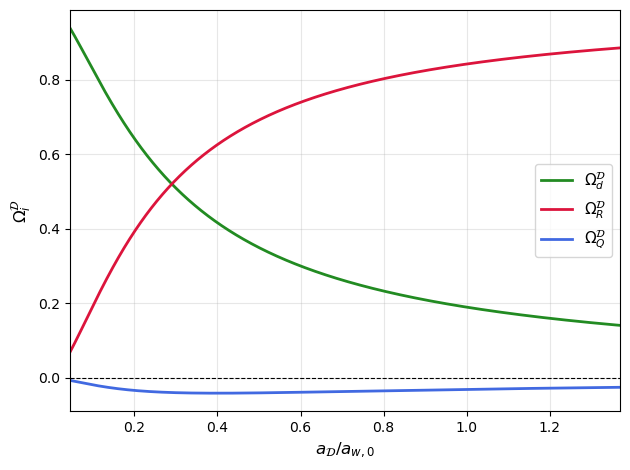

In [11]:
plt.plot(a(tf), OmegaM, label=r'$\Omega^\mathcal{D}_d$', color='forestgreen', lw=2)
plt.plot(a(tf), OmegaR, label=r'$\Omega^\mathcal{D}_R$', color='crimson', lw=2)
plt.plot(a(tf), OmegaQ, label=r'$\Omega^\mathcal{D}_Q$', color='royalblue', lw=2)
plt.axhline(0, color='k', linestyle='--', lw=0.8)
plt.xlabel(r'$a_{\mathcal{D}}/a_{w,0}$', fontsize=12)
plt.ylabel(r'$\Omega^\mathcal{D}_i$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([a(tf[0]),a(tf[-1])])
plt.tight_layout()
plt.savefig('TImescape_energy_balance.pdf', format='pdf')
plt.show()

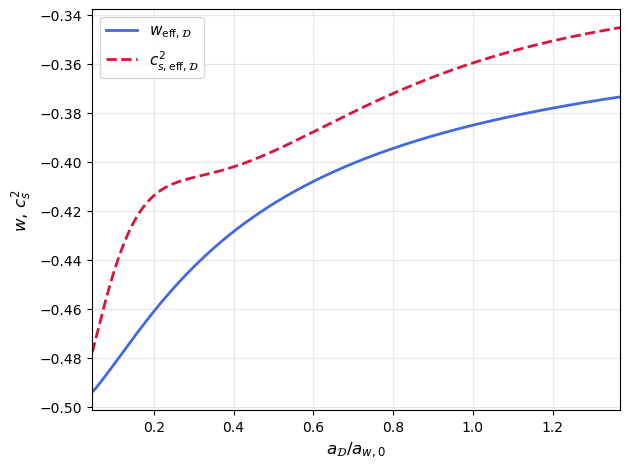

In [12]:
plt.plot(a(tf), wEffarr, label=r'$w_{\mathrm{eff},\mathcal{D}}$', color='royalblue', lw=2)
plt.plot(a(tf), cs2Effarr, '--', label=r'$c_{s,\mathrm{eff},\mathcal{D}}^2$', color='crimson', lw=2)
plt.xlabel(r'$a_{\mathcal{D}}/a_{w,0}$', fontsize=12)
plt.ylabel(r'$w$, $c_{s}^2$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([a(tf[0]),a(tf[-1])])
plt.tight_layout()
plt.savefig('Timescape_wcs.pdf', format='pdf')
plt.show()

In [13]:
def solnum_barotropic(k,t_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(t):
        return -4*np.pi*G*rhod(t)

    def A22(t):
        return -(2/3)*Theta(t)

    def A23(t):
        term1 = -4*np.pi*G*rhoEff(t)
        term2 = 1+3*cs2Eff(t)
        return term1*term2

    def A32(t):
        return -(1+wEff(t))

    def A33(t):
        return (wEff(t)+cs2Eff(t))*Theta(t)

    def A34(t):
        return ((k**2)/a(t))*(1+wEff(t))

    def A43(t):
        term1 = -cs2Eff(t)/a(t)
        term2 = (1+wEff(t))
        return term1/term2

    def A44(t):
        term1 = Theta(t)/3
        term2 = (3*cs2Eff(t)-1)
        return term1*term2
    # Define a 4x4 time-dependent matrix A(t) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_morphon; 4. Tilt_morphon
    def A(t):
        return np.array([
            [  0,        -1,        0,          0   ],
            [A21(t),    A22(t),   A23(t),       0   ],
            [  0,       A32(t),   A33(t),     A34(t)],
            [  0,         0,      A43(t),     A44(t)]
        ])
    
    # Define the ODE system: dv/dt = A(t) @ v
    def system(t, v):
        return A(t) @ v
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    # Solve the system
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval)  

    return sol

In [14]:
def solnum_comoving(t_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(t):
        return -4*np.pi*G*rhod(t)

    def A22(t):
        return -(2/3)*Theta(t)

    def A23(t):
        return -4*np.pi*G*rhoEff(t)

    def A32(t):
        return -(1+wEff(t))

    def A33(t):
        return wEff(t)*Theta(t)

    # Define a 4x4 time-dependent matrix A(t) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_morphon;
    def A(t):
        return np.array([
            [  0,        -1,        0     ],
            [A21(t),    A22(t),   A23(t)  ],
            [  0,       A32(t),   A33(t)  ]
        ])
    
    # Define the ODE system: dv/dt = A(t) @ v
    def system(t, v):
        return A(t) @ v
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    ic = ic[:-1]  # remove the V_Eff initial condition
    # Solve the system
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval)  

    return sol

In [15]:
# Mezaros Approximation
def solnum_mezaros(t_eval,ic):

    def perturbation_equation(t,y):
        delta, delta_dot = y
        H = Theta(t)/3
        rho_t = rhod(t)
        delta_ddot = 4 * np.pi * G * rho_t * delta - 2 * H * delta_dot
        return [delta_dot, delta_ddot]
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    ic_new = np.array([ic[0],-ic[1]])
    
    sol = solve_ivp(perturbation_equation,t_span,ic_new,t_eval=t_eval)

    return sol

In [16]:
# Time evaluation points
t_eval = np.linspace(0.218*GyrstoHT, t0, 1000)

# Initial condition (4D vector) fixed to be the initial condition for a typical dust perturbation on a co-moving scale of 150 Mpc/h at present time in the concordance model
ic = [0.0031427229788258105, -0.16974050039281288, 0, 0]

In [17]:
sol_comoving = solnum_comoving(t_eval,ic)
sol_mezaros = solnum_mezaros(t_eval,ic)

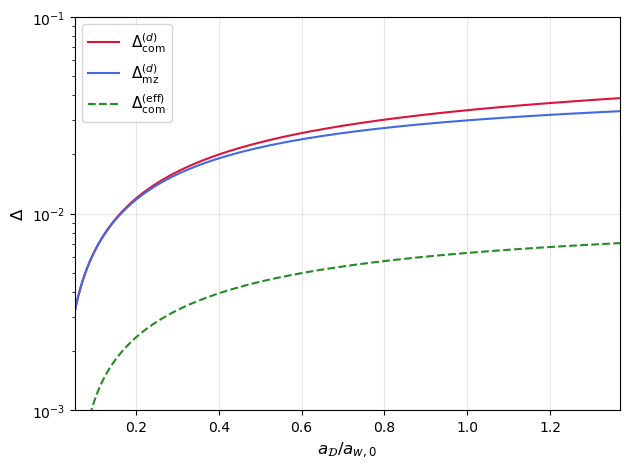

In [18]:
labels_com = [r'$\Delta^{(d)}_{\mathrm{com}}$', r'$\Delta^{(\mathrm{eff})}_{\mathrm{com}}$']
labels_mz = [r'$\Delta^{(d)}_{\mathrm{mz}}$']

plt.plot([a(t) for t in sol_comoving.t], sol_comoving.y[0], label=labels_com[0],color = 'crimson')
plt.plot([a(t) for t in sol_mezaros.t], sol_mezaros.y[0], label=labels_mz, color = 'royalblue')
plt.plot([a(t) for t in sol_comoving.t], sol_comoving.y[2], '--', label=labels_com[1], color = 'forestgreen')
plt.xlabel(r'$a_{\mathcal{D}}/a_{w,0}$', fontsize=12)
plt.ylabel(r'$\Delta$', fontsize=12)
plt.xlim([a(t_eval[0]),a(t_eval[-1])])
plt.ylim([1e-3,1e-1])
plt.yscale('log')
plt.grid(alpha = 0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('All_Perturbations_Timescape.pdf', format='pdf')
plt.show()

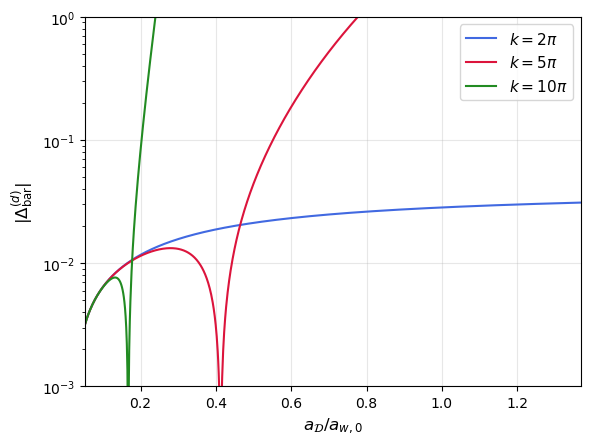

In [19]:
k_vector = [2*np.pi, 5*np.pi, 10*np.pi]
labels_k = [r'$k = 2\pi$',r'$k = 5\pi$',r'$k = 10\pi$']
sol_bar = {}
colors = ['royalblue','crimson','forestgreen']

for i in range(len(k_vector)):
    k = k_vector[i]
    sol_bar[k] = solnum_barotropic(k,t_eval,ic)
    plt.plot([a(t) for t in sol_bar[k].t], np.abs(sol_bar[k].y[0]), label=labels_k[i], color = colors[i])
    
plt.ylim([1e-3,1])
plt.yscale('log')
plt.xlabel(r'$a_{\mathcal{D}}/a_{w,0}$', fontsize=12)
plt.ylabel(r'$|\Delta^{(d)}_\mathrm{bar}|$', fontsize=12)
plt.xlim([a(t_eval[0]),a(t_eval[-1])])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_Dusts_Timescape.pdf', format='pdf')
plt.show()

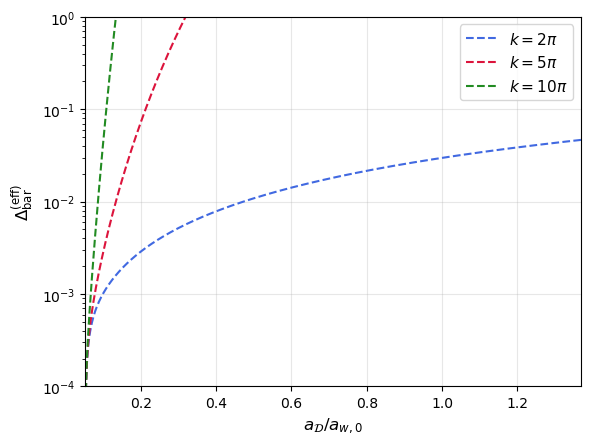

In [20]:
for i in range(len(k_vector)):
    k = k_vector[i]
    plt.plot([a(t) for t in sol_bar[k].t], np.abs(sol_bar[k].y[2]),'--', label=labels_k[i], color = colors[i])
    
plt.ylim([1e-4,1])
plt.yscale('log')
plt.xlabel(r'$a_{\mathcal{D}}/a_{w,0}$', fontsize=12)
plt.xlim([a(t_eval[0]),a(t_eval[-1])])
plt.ylabel(r'$\Delta^{(\mathrm{eff})}_\mathrm{bar}$', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_Eff_Timescape.pdf', format='pdf')
plt.show()